# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Desired Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)||Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL||Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

In [1]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

Files = []
df = []
df_speed = pd.DataFrame()

for filename in os.listdir( dir_sanofi_share + folder ):
    if filename.endswith('_SPEED.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_speed = df_speed.append(df)




In [4]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_speed.set_index('IP_TREND_TIME', inplace=True)

Tags for Machine speeds:

|IP_TAG Name   |Machine|Desired Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 used but 35|   
|36640901_SPEED|Labeler|500|   
|36650901_SPEED|Packaging (Pacemaker!)|450 (3pcs) or 500 (5pcs)|   
|36680901_SPEED|Cartoner||   
|36680902_SPEED|Palletizer||    

In [5]:
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'

df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Max_Speed'] = 32
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Max_Speed'] = 500
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Max_Speed'] = 450
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Max_Speed'] = 0
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Max_Speed'] = 0


In [6]:
df_speed['IP_TREND_VALUE'] = pd.to_numeric(df_speed['IP_TREND_VALUE'])
df_speed['Max_Speed'] = pd.to_numeric(df_speed['Max_Speed'])

df_speed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321969 entries, 2021-08-19 20:19:32.500000 to 2021-08-01 00:09:14.200000
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Name              321969 non-null  object
 1   IP_TREND_VALUE    321969 non-null  int64 
 2   IP_TREND_QLEVEL   321969 non-null  object
 3   IP_TREND_QSTATUS  321969 non-null  object
 4   Filename          321969 non-null  object
 5   Machine           321969 non-null  object
 6   Max_Speed         321969 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 19.7+ MB


In [7]:
#  drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

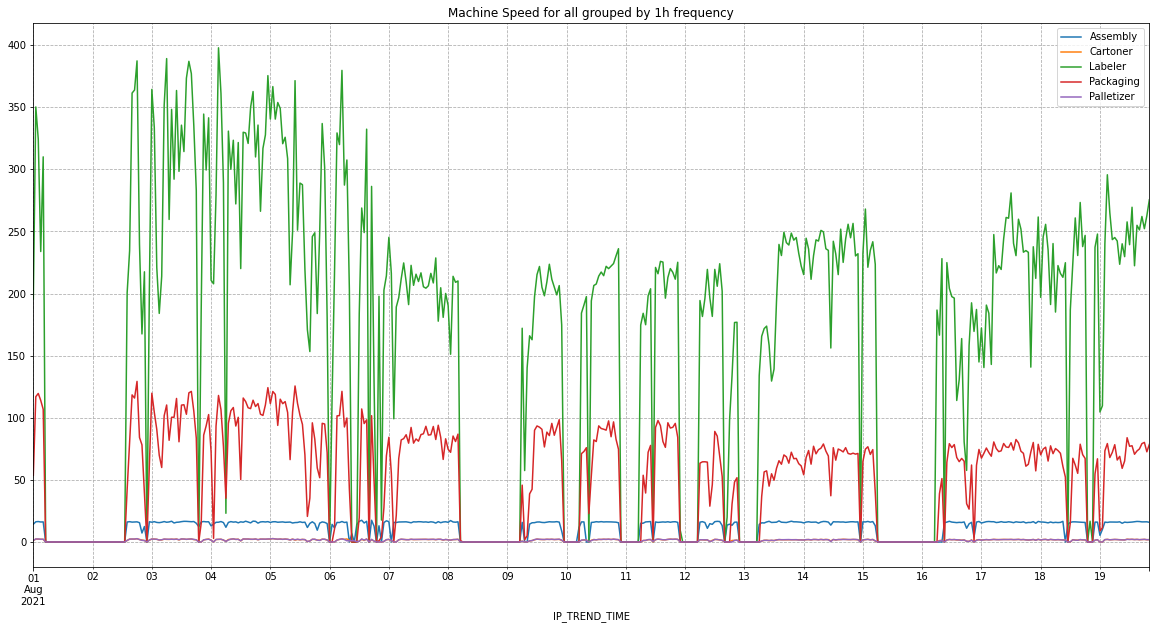

In [11]:
freq='1h'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('IP_TREND_TIME', inplace=True)

machines = group.Machine.unique()

fig, axs = plt.subplots(1, 1, figsize=(20, 10))

for x in machines:
    group['IP_TREND_VALUE'][group.Machine == x].plot(label=x, ax=axs)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed for all grouped by {} frequency'.format(freq))

    axs.legend()

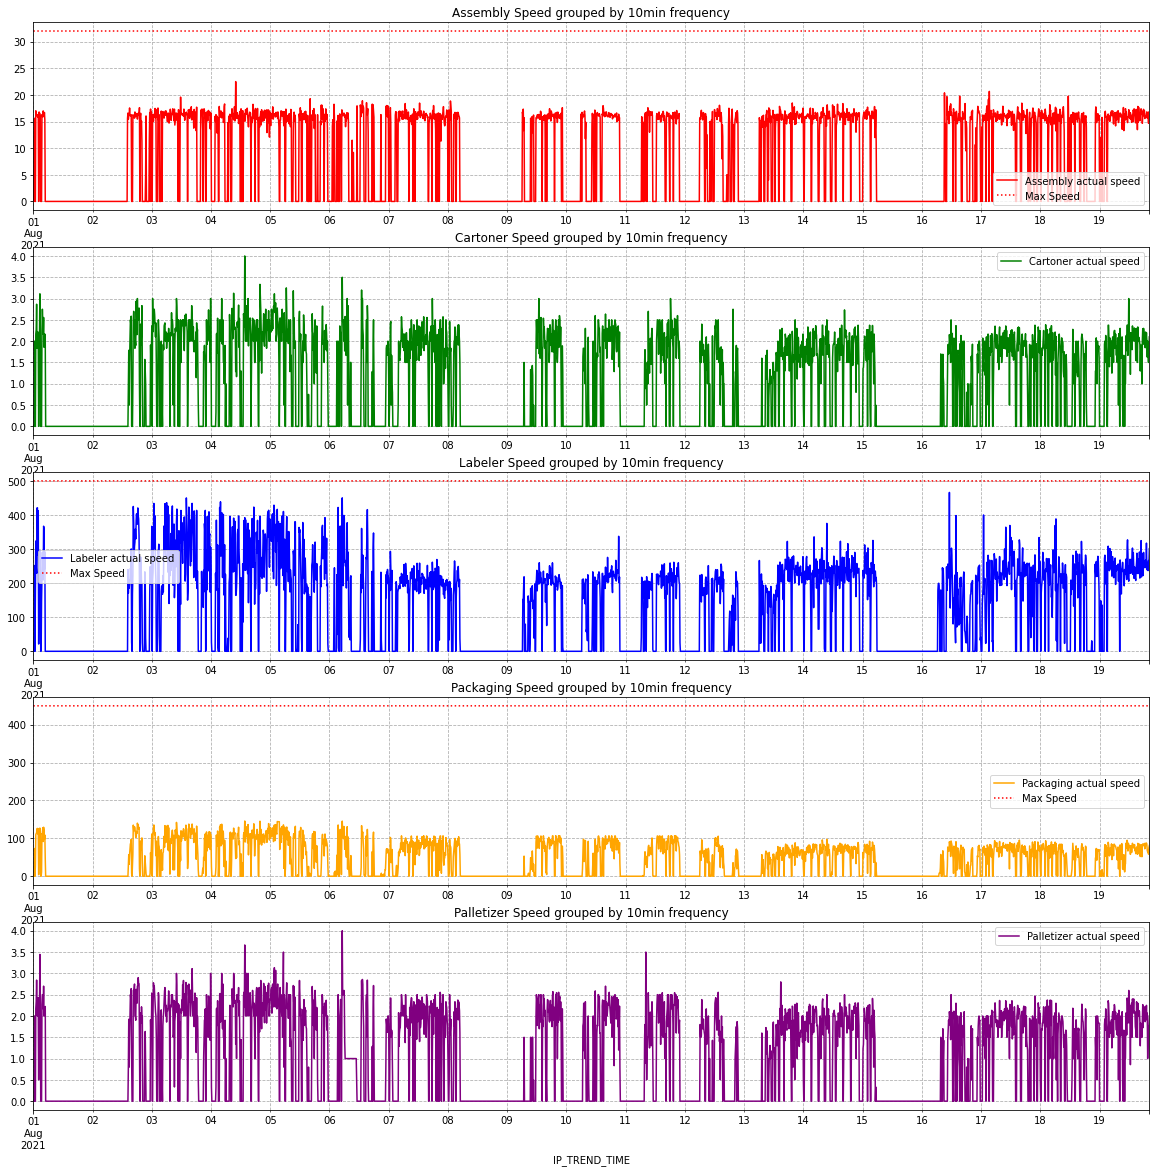

In [198]:
freq='10min'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('IP_TREND_TIME', inplace=True)

machines = group.Machine.unique()

fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "green", "blue", "orange", "purple")
i=0

for x in machines:
    group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i])
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    axs[i].plot()
    axs[i].legend()
    i+=1

In [215]:
df_speed.groupby('Machine')['IP_TREND_VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
Machine,,,,,,,,
Assembly,101310.0,15.935258,14.070723,0.0,0.0,16.0,32.0,32.0
Cartoner,16162.0,1.846554,1.112547,0.0,1.0,2.0,3.0,6.0
Labeler,91228.0,253.232056,167.685873,0.0,70.0,263.0,400.0,500.0
Packaging,96934.0,82.898550,42.307921,0.0,48.0,96.0,108.0,152.0
Palletizer,16335.0,1.859627,1.109669,0.0,1.0,2.0,3.0,5.0


In [274]:
# mean speed by day of week
df_speed.groupby(df_speed.index.dayofweek)['IP_TREND_VALUE'].mean().reset_index()

,IP_TREND_TIME,IP_TREND_VALUE
0,0,85.847166
1,1,110.650675
2,2,113.521409
3,3,110.192307
4,4,103.531043
5,5,82.655609
6,6,89.664495


<AxesSubplot:title={'center':'np.percentile(packaging.IP_TREND_VALUE, 25)'}, xlabel='IP_TREND_TIME'>

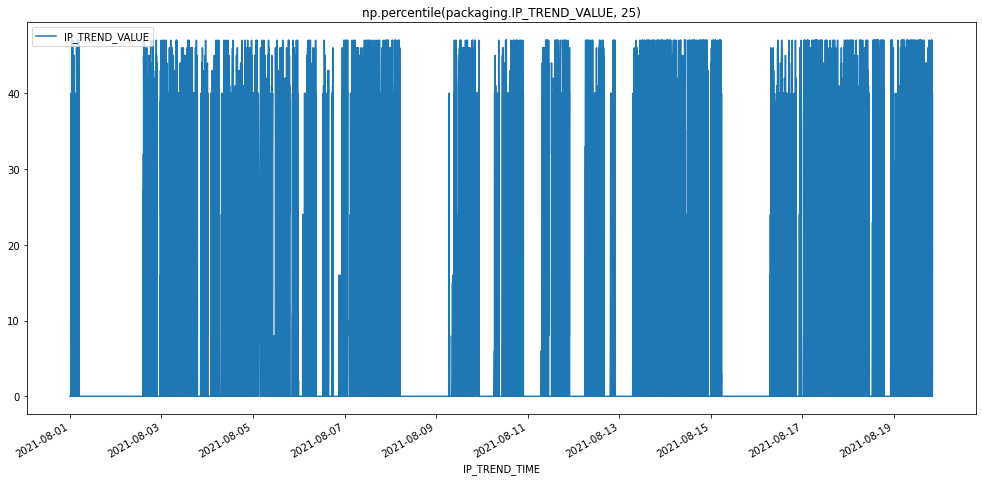

In [293]:
# get the rows for packaging where the speed is < 25% percentile
packaging = df_speed[['Machine','IP_TREND_VALUE']][df_speed.Machine == 'Packaging']
packaging[packaging.IP_TREND_VALUE < np.percentile(packaging.IP_TREND_VALUE, 25)].plot(figsize=(17,8), title='np.percentile(packaging.IP_TREND_VALUE, 25)')


<AxesSubplot:title={'center':'np.percentile(packaging.IP_TREND_VALUE, 75)'}, xlabel='IP_TREND_TIME'>

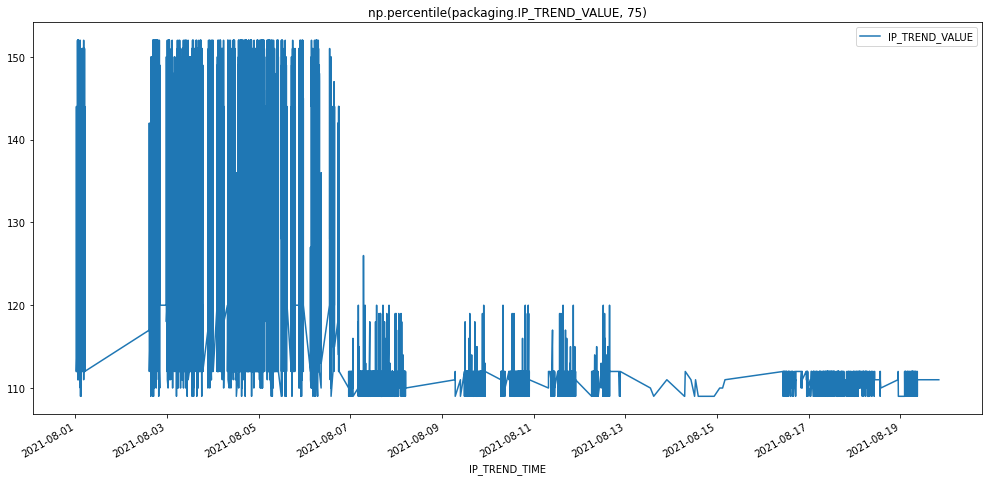

In [294]:
packaging[packaging.IP_TREND_VALUE > np.percentile(packaging.IP_TREND_VALUE, 75)].plot(figsize=(17,8), title='np.percentile(packaging.IP_TREND_VALUE, 75)')